# Giriş

Çok sayıda değişkenle çalışırken, modelinizin performansını artırmak için değişken seçimi yapmak yararlı olabilir. Feature importance, SHAP değerleri, permutation score ve MI score gibi değişken önem ölçüleri, değişkenlerin modellerdeki etkilerini değerlendirmek için yaygın olarak kullanılan yöntemlerdir.

Bu ölçümlerden her biri, değişkenlerin modele katkısını farklı bir açıdan değerlendirdiği için tek başına yeterli olmayabilir. Ancak, birbirleriyle birleştirerek daha güçlü bir seçim yapabilirsiniz. Bu kernelde feature selection için bu değerlerin kombinasyonu ile önemli değişkenler seçilmesi çalışması yapılacaktır

In [1]:
!pip install --pre pycaret;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.1/480.1 kB 6.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 13.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 4.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 54.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 

In [2]:
#Gerekli kütüphanelerin cagırılması
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import eli5
from eli5.sklearn import PermutationImportance
from pycaret.classification import *
import shap
import xgboost as xgb
import lightgbm as lb
import catboost as ct

# Verilerin yüklenmesi ve ön işleme

Veri ön işleme çok kısa tutulacak. Orjinal veri ile yarışma verisi birleştirilecektir. Yeni feature üretimi için daha önceki çalışmalardan yararlanılmışdır.

#### Feature Engineering icin kodlar, @cv13j0 "Auto ML Model Using PyCaret" isimli çalışmasından alınmıştır
#### Kaynak:  https://www.kaggle.com/code/cv13j0/auto-ml-model-using-pycaret

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s3e7/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e7/test.csv")
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1


In [4]:
org_df = pd.read_csv("/kaggle/input/reservation-cancellation-prediction/train__dataset.csv")
org_df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18132,1,0,0,2,0,0,0,103,2018,4,19,0,0,0,0,115.00,0,1
18133,2,0,0,3,0,0,0,129,2018,8,10,1,0,0,0,88.01,1,0
18134,2,0,0,1,0,0,0,90,2018,7,13,1,0,0,0,105.30,0,1
18135,2,0,0,3,0,0,0,18,2018,11,10,1,1,0,1,123.33,1,0


In [5]:
df = pd.concat([train.drop('id', axis = 1), org_df], axis = 0)
df.reset_index(drop = True, inplace = True)
df.drop_duplicates(inplace = True)
df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60228,2,0,1,1,2,0,0,35,2018,10,15,1,0,0,0,148.60,2,0
60231,2,0,0,5,0,0,0,205,2018,7,26,1,0,0,0,70.03,1,1
60234,2,0,0,1,0,0,0,90,2018,7,13,1,0,0,0,105.30,0,1
60235,2,0,0,3,0,0,0,18,2018,11,10,1,1,0,1,123.33,1,0


In [6]:
def feature_engineering(df):
  
    df['family_size'] = df['no_of_adults'] + df['no_of_children']
    df['total_nights'] = df['no_of_weekend_nights'] + df['no_of_week_nights']
    df['total_bookings'] = df['no_of_previous_cancellations'] + df['no_of_previous_bookings_not_canceled']
    df['total_cost'] = df['total_nights'] * df['avg_price_per_room']
    
    return df



Modelin veriyi daha iyi anlamasına yardımcı ola bilecek bazı değişkenler türetilmiştir

In [7]:
def correct_days_in_month(df):
        
        df['arrival_year_month'] = pd.to_datetime(df['arrival_year'].astype(str) + df['arrival_month'].astype(str), format = '%Y%m')
        df.loc[df.arrival_date > df.arrival_year_month.dt.days_in_month, 'arrival_date'] = df.arrival_year_month.dt.days_in_month
        df.drop(columns='arrival_year_month', inplace=True)
        return df

Bu fonksiyonun amacı, var olan bir DataFrame'deki 'arrival_date' sütununda bulunan günleri o ayın gün sayısına uygun hale getirmek. Örneğin, Şubat ayı için 'arrival_date' sütununda 30 yazan bir veriyi 28'e düşürmek.

Fonksiyonun çalışma mantığı şu şekilde:

1. 'arrival_year' ve 'arrival_month' sütunları kullanılarak, bir 'arrival_year_month' sütunu  oluşturulur. Bu sütun, yıl ve ayın birleşimi olarak gösterilir.

2. 'arrival_date' sütunu, 'arrival_year_month' sütunundaki ayın gün sayısına göre düzenlenir. Eğer 'arrival_date' sütununda, o ayın gün sayısından büyük bir değer varsa, bu değer o ayın son gününe eşitlenir.

3. 'arrival_year_month' sütunu, fonksiyon sonunda veriden kaldırılır.



In [8]:
def removing_odd_data(df):
    df = df[(df['total_nights'] > 0) & (df['family_size'] > 0)] 
    return df

Bu fonksiyon, veri setinden belirli şartları sağlamayan satırları kaldırmak için kullanılıyor.

Fonksiyonun çalışma mantığı şu şekildedir:

1. Verilen DataFrame'in 'total_nights' ve 'family_size' sütunlarındaki değerler kontrol edilir.

2. 'total_nights' sütunu, sıfırdan büyük olmalıdır.

3. 'family_size' sütunu, sıfırdan büyük olmalıdır.

4. Bu şartları sağlamayan satırlar, veri setinden kaldırılır.

5. Düzenlenmiş DataFrame, fonksiyon tarafından geri döndürülür.

In [9]:
df = feature_engineering(df)
df = correct_days_in_month(df)
df = removing_odd_data(df)
df

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,...,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,family_size,total_nights,total_bookings,total_cost
0,2,0,0,2,1,0,0,9,2018,1,...,1,11,0,67.50,0,0,2,2,11,135.00
1,2,0,1,2,0,0,0,117,2018,7,...,0,0,0,72.25,0,0,2,3,0,216.75
2,2,0,0,1,0,0,0,315,2018,12,...,0,0,0,52.00,0,0,2,1,0,52.00
3,1,0,0,2,1,0,0,32,2018,12,...,0,0,0,56.00,0,0,1,2,0,112.00
4,2,0,1,0,0,0,0,258,2018,10,...,0,0,0,100.00,0,1,2,1,0,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60228,2,0,1,1,2,0,0,35,2018,10,...,0,0,0,148.60,2,0,2,2,0,297.20
60231,2,0,0,5,0,0,0,205,2018,7,...,0,0,0,70.03,1,1,2,5,0,350.15
60234,2,0,0,1,0,0,0,90,2018,7,...,0,0,0,105.30,0,1,2,1,0,105.30
60235,2,0,0,3,0,0,0,18,2018,11,...,1,0,1,123.33,1,0,2,3,1,369.99


In [10]:
X = df.drop(['booking_status'], axis = 1)
y = df['booking_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
print(f'test target distribution => {y_test.value_counts()/y_test.shape[0]}\ntrain target distribution => {y_train.value_counts()/y_train.shape[0]}')

test target distribution => 0    0.633583
1    0.366417
Name: booking_status, dtype: float64
train target distribution => 0    0.633534
1    0.366466
Name: booking_status, dtype: float64


Target dağılımı train ve test icin ayni oranda olacak şekilde ayarlandı.

# Mutual Information değerlerinin hesaplanması

Kaynaklar

1. https://www.kaggle.com/code/ryanholbrook/mutual-information
2. https://bobrupakroy.medium.com/mutual-information-score-feature-selection-8eb19071664b
3. https://en.wikipedia.org/wiki/Mutual_information
4. https://quantdare.com/what-is-mutual-information/

In [11]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# create a boolean array indicating which features are discrete
discrete_features = np.array([len(np.unique(X[col])) < 10 for col in X.columns])

mi_scores = make_mi_scores(X, y, discrete_features = discrete_features)
mi_scores

lead_time                               0.117860
avg_price_per_room                      0.095800
total_cost                              0.084205
market_segment_type                     0.038930
no_of_special_requests                  0.032246
arrival_month                           0.027858
arrival_year                            0.016899
repeated_guest                          0.012409
total_bookings                          0.010965
no_of_previous_bookings_not_canceled    0.010642
total_nights                            0.006002
required_car_parking_space              0.005722
family_size                             0.005719
no_of_adults                            0.005607
no_of_week_nights                       0.005210
no_of_previous_cancellations            0.002130
type_of_meal_plan                       0.002048
arrival_date                            0.002010
no_of_weekend_nights                    0.001507
room_type_reserved                      0.001375
no_of_children      

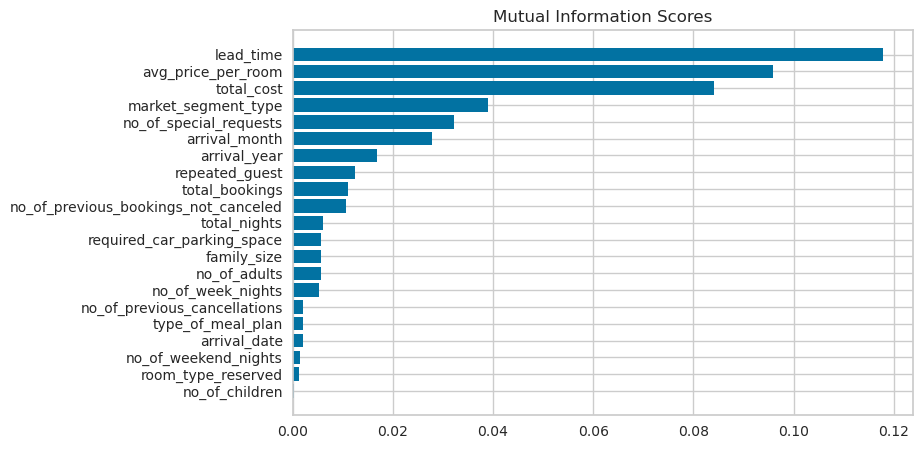

In [12]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [13]:
mi_df = pd.DataFrame(mi_scores).reset_index().rename(columns={'index': 'Features', 'MI Scores':'mi_scores'})
mi_df['mi_scores'] = MinMaxScaler().fit_transform(mi_df[['mi_scores']])
mi_df

,Features,mi_scores
0,lead_time,1.000000
1,avg_price_per_room,0.812358
2,total_cost,0.713737
3,market_segment_type,0.328636
4,no_of_special_requests,0.271781
5,arrival_month,0.234463
6,arrival_year,0.141246
7,repeated_guest,0.103057
8,total_bookings,0.090769
9,no_of_previous_bookings_not_canceled,0.088023


# Permutation Importance değerlerinin hesaplanması

Kaynaklar

1. https://www.kaggle.com/code/dansbecker/permutation-importance
2. https://www.geeksforgeeks.org/machine-learning-explainability-using-permutation-importance/
3. https://medium.com/@T_Jen/feature-importance-for-any-model-using-permutation-7997b7287aa
4. https://medium.com/@gauravagarwal_14599/explainable-ai-xai-permutation-feature-importance-7be0da6f0600

Permutasyon değerlerini hesaplamak icin öncelikle bir model kullanmamız lazim. Hangi modeli kullanmamız gerekir bulmak icin pycaret kutuphanesini kullanacağım

In [14]:
pipline = setup(data = pd.concat([X_train, y_train], axis = 1), 
                target = 'booking_status',
                data_split_stratify = True,
                train_size = 0.8, 
                session_id = 42)

,Description,Value
0,Session id,42
1,Target,booking_status
2,Target type,Binary
3,Original data shape,"(40806, 22)"
4,Transformed data shape,"(40806, 22)"
5,Transformed train set shape,"(32644, 22)"
6,Transformed test set shape,"(8162, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


In [15]:
models = compare_models(sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8257,0.8953,0.7242,0.7837,0.7528,0.6184,0.6196,12.6480
lightgbm,Light Gradient Boosting Machine,0.8239,0.8948,0.7190,0.7828,0.7495,0.6141,0.6155,1.0330
xgboost,Extreme Gradient Boosting,0.8265,0.8945,0.7330,0.7804,0.7559,0.6215,0.6223,2.1700
gbc,Gradient Boosting Classifier,0.8139,0.8802,0.6840,0.7809,0.7292,0.5884,0.5914,1.8890
rf,Random Forest Classifier,0.8050,0.8689,0.6951,0.7537,0.7232,0.5730,0.5742,2.1850
ada,Ada Boost Classifier,0.7958,0.8670,0.6875,0.7375,0.7116,0.5538,0.5547,0.7230
et,Extra Trees Classifier,0.7908,0.8349,0.6843,0.7287,0.7057,0.5437,0.5445,2.2310
lda,Linear Discriminant Analysis,0.7681,0.8322,0.6198,0.7105,0.6620,0.4868,0.4895,0.1140
lr,Logistic Regression,0.7687,0.8314,0.6175,0.7129,0.6617,0.4873,0.4903,2.0100
nb,Naive Bayes,0.4256,0.7890,0.9897,0.3886,0.5581,0.0671,0.1718,0.0550


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [16]:
best_model = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8279,0.8987,0.7308,0.7846,0.7567,0.6238,0.6247
1,0.8230,0.8948,0.7226,0.7786,0.7496,0.6130,0.6140
2,0.8242,0.8986,0.7235,0.7809,0.7511,0.6155,0.6166
3,0.8156,0.8894,0.6984,0.7762,0.7353,0.5944,0.5964
4,0.8266,0.8929,0.7383,0.7773,0.7573,0.6225,0.6230
5,0.8183,0.8893,0.7174,0.7709,0.7432,0.6029,0.6038
6,0.8392,0.9056,0.7391,0.8058,0.7710,0.6474,0.6489
7,0.8226,0.8920,0.7232,0.7772,0.7492,0.6123,0.6132
8,0.8321,0.8958,0.7349,0.7919,0.7624,0.6328,0.6339


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
perm = PermutationImportance(best_model, random_state=1, scoring = make_scorer(roc_auc_score) ).fit(X_test, y_test)
weights = np.array(perm.feature_importances_)
feature_names = X_test.columns.tolist()
feature_weights = list(zip(feature_names, weights))
perm_df = pd.DataFrame(feature_weights, columns=['Features', 'Permutation Score']).sort_values(by='Permutation Score', ascending=False)
perm_df['Permutation Score'] = MinMaxScaler().fit_transform(perm_df[['Permutation Score']])
perm_df

,Features,Permutation Score
7,lead_time,1.000000
16,no_of_special_requests,0.742619
11,market_segment_type,0.422633
15,avg_price_per_room,0.408106
9,arrival_month,0.127339
5,required_car_parking_space,0.057591
8,arrival_year,0.033198
6,room_type_reserved,0.026851
10,arrival_date,0.025798
0,no_of_adults,0.023738


# Shap değerlerinin hesaplanması

Kaynaklar

1. https://medium.com/turkcell/shap-i%CC%87le-a%C3%A7%C4%B1klanabilir-yapay-zeka-explainable-ai-xai-b39339f18199
2. https://dergipark.org.tr/tr/download/article-file/1973144
3. https://medium.com/@tarikkaan1koc/shap-analizi-shap-de%C4%9Ferleriyle-makine-%C3%B6%C4%9Frenimi-modelleri-nas%C4%B1l-yorumlan%C4%B1r-e95710e4aa0c
4. https://www.kaggle.com/code/dansbecker/shap-values
5. https://dev.to/mage_ai/how-to-interpret-machine-learning-models-with-shap-values-54jf

In [18]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# her bir özellik için ortalama shap değerlerinin hesaplanması
mean_shap_values = np.abs(shap_values).mean(axis=0)

# shap değerlerinin bir DataFrame'e dönüştürülmesi
shap_df = pd.DataFrame({'Features': X_test.columns, 'SHAP Values': mean_shap_values})
shap_df = shap_df.sort_values(by='SHAP Values', ascending=False).reset_index(drop=True)
shap_df['SHAP Values'] = MinMaxScaler().fit_transform(shap_df[['SHAP Values']])
shap_df

,Features,SHAP Values
0,no_of_special_requests,1.000000
1,lead_time,0.989201
2,market_segment_type,0.623558
3,avg_price_per_room,0.470123
4,arrival_month,0.291222
5,required_car_parking_space,0.123327
6,arrival_year,0.117089
7,arrival_date,0.104612
8,total_cost,0.082044
9,no_of_adults,0.058210


# Feature importance değerlerinin hesaplanması

Kaynaklar

1. https://machinelearningmastery.com/calculate-feature-importance-with-python/
2. https://www.codecademy.com/article/fe-feature-importance-final
3. https://christophm.github.io/interpretable-ml-book/feature-importance.html

In [19]:
feature_weights = best_model.feature_importances_

# Özellik adlarını alın
feature_names = X_train.columns

# Özellik ağırlıklarını bir pandas DataFrame'ine dönüştürün
feature_importances = pd.DataFrame({'Features': feature_names, 'importance': feature_weights})

# Özellik ağırlıklarını önem sırasına göre sıralayın
fi_df = feature_importances.sort_values('importance', ascending=False)
fi_df['importance'] = MinMaxScaler().fit_transform(fi_df[['importance']])
fi_df

,Features,importance
7,lead_time,1.000000
16,no_of_special_requests,0.774346
15,avg_price_per_room,0.549469
11,market_segment_type,0.414807
9,arrival_month,0.307429
10,arrival_date,0.168219
20,total_cost,0.143321
5,required_car_parking_space,0.110756
8,arrival_year,0.078814
3,no_of_week_nights,0.077902


In [20]:
final_df = pd.merge(fi_df, shap_df, on='Features')
final_df = pd.merge(final_df, mi_df, on='Features')
final_df = pd.merge(final_df, perm_df, on='Features')
final_df

,Features,importance,SHAP Values,mi_scores,Permutation Score
0,lead_time,1.000000,0.989201,1.000000,1.000000
1,no_of_special_requests,0.774346,1.000000,0.271781,0.742619
2,avg_price_per_room,0.549469,0.470123,0.812358,0.408106
3,market_segment_type,0.414807,0.623558,0.328636,0.422633
4,arrival_month,0.307429,0.291222,0.234463,0.127339
5,arrival_date,0.168219,0.104612,0.014600,0.025798
6,total_cost,0.143321,0.082044,0.713737,0.015480
7,required_car_parking_space,0.110756,0.123327,0.046177,0.057591
8,arrival_year,0.078814,0.117089,0.141246,0.033198
9,no_of_week_nights,0.077902,0.057591,0.041825,0.012460


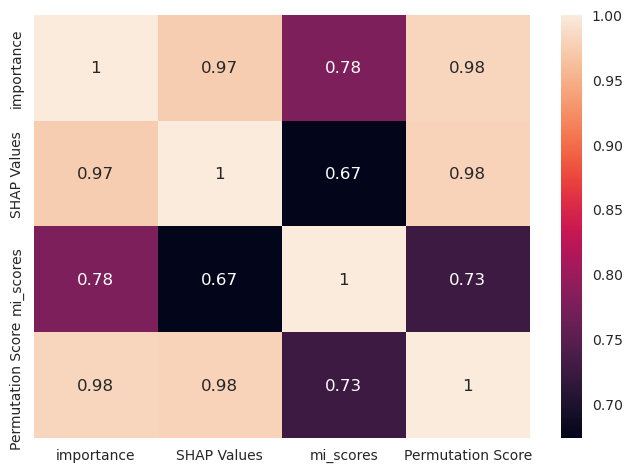

In [21]:
sns.heatmap(final_df.corr(), annot = True);

In [22]:
final_df['final_score'] = final_df.mean(axis = 1)
final_df = final_df.sort_values(by = 'final_score', ascending = False)
final_df

,Features,importance,SHAP Values,mi_scores,Permutation Score,final_score
0,lead_time,1.000000,0.989201,1.000000,1.000000,0.997300
1,no_of_special_requests,0.774346,1.000000,0.271781,0.742619,0.697186
2,avg_price_per_room,0.549469,0.470123,0.812358,0.408106,0.560014
3,market_segment_type,0.414807,0.623558,0.328636,0.422633,0.447409
4,arrival_month,0.307429,0.291222,0.234463,0.127339,0.240113
6,total_cost,0.143321,0.082044,0.713737,0.015480,0.238646
8,arrival_year,0.078814,0.117089,0.141246,0.033198,0.092587
7,required_car_parking_space,0.110756,0.123327,0.046177,0.057591,0.084462
5,arrival_date,0.168219,0.104612,0.014600,0.025798,0.078307
9,no_of_week_nights,0.077902,0.057591,0.041825,0.012460,0.047445


In [23]:
select_columns = list(final_df[:15]['Features'])

Final skoru en yüksek olan 15 değişken son model için seçilmiştir

In [25]:
X_train_new = X_train[select_columns]
X_train_new

,lead_time,no_of_special_requests,avg_price_per_room,market_segment_type,arrival_month,total_cost,arrival_year,required_car_parking_space,arrival_date,no_of_week_nights,total_bookings,repeated_guest,no_of_previous_bookings_not_canceled,no_of_adults,family_size
18443,126,0,118.80,1,9,118.8,2018,0,6,1,0,0,0,2,2
15336,112,0,127.80,1,8,511.2,2018,0,9,4,0,0,0,2,2
658,159,0,114.30,1,8,342.9,2018,0,9,3,0,0,0,2,2
54050,28,1,122.00,1,9,244.0,2018,0,1,2,0,0,0,2,2
13390,313,2,79.50,1,12,238.5,2018,0,1,3,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54782,84,0,137.70,1,7,137.7,2018,0,13,1,0,0,0,3,3
11243,145,0,184.95,1,8,1479.6,2018,0,24,6,0,0,0,2,4
35547,10,0,157.00,1,3,471.0,2018,0,25,2,0,0,0,3,3
19528,99,1,137.10,1,6,411.3,2018,0,9,3,0,0,0,2,2


In [26]:
pipline = setup(data = pd.concat([X_train_new, y_train], axis = 1), 
                target = 'booking_status',
                data_split_stratify = True,
                train_size = 0.8, 
                session_id = 42)

,Description,Value
0,Session id,42
1,Target,booking_status
2,Target type,Binary
3,Original data shape,"(40806, 16)"
4,Transformed data shape,"(40806, 16)"
5,Transformed train set shape,"(32644, 16)"
6,Transformed test set shape,"(8162, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


In [27]:
best_model2 = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8257,0.8983,0.7258,0.7827,0.7531,0.6188,0.6198
1,0.8254,0.8949,0.7310,0.7792,0.7543,0.6191,0.6199
2,0.8285,0.8981,0.7243,0.7903,0.7559,0.6241,0.6255
3,0.8144,0.8873,0.6984,0.7734,0.7340,0.5920,0.5938
4,0.8226,0.8926,0.7408,0.7671,0.7537,0.6152,0.6154
5,0.8205,0.8897,0.7224,0.7728,0.7468,0.6079,0.6088
6,0.8361,0.9052,0.7299,0.8046,0.7655,0.6399,0.6417
7,0.8205,0.8915,0.7157,0.7768,0.7450,0.6068,0.6080
8,0.8290,0.8951,0.7291,0.7884,0.7576,0.6259,0.6270


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Model performansı çok az değişti. O yüzden feature selection başarılı sayılabilir. 

# Model geliştirme ve tahmin

In [28]:
test = pd.read_csv('/kaggle/input/playground-series-s3e7/test.csv')
test.drop('id', axis = 1, inplace = True)
test.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2
1,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0
2,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1
3,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0
4,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0


In [29]:
test = feature_engineering(test)
test = correct_days_in_month(test)
test

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,...,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,family_size,total_nights,total_bookings,total_cost
0,3,0,1,4,0,0,1,111,2018,12,...,1,0,0,0,115.60,2,3,5,0,578.00
1,2,0,0,3,0,0,0,22,2017,10,...,0,0,0,0,85.00,0,2,3,0,255.00
2,2,2,0,1,0,0,3,18,2018,8,...,1,0,0,0,240.00,1,4,1,0,240.00
3,2,0,0,3,0,0,0,88,2018,5,...,0,0,0,0,80.75,0,2,3,0,242.25
4,1,0,0,2,2,0,0,7,2018,9,...,1,0,0,0,144.00,0,1,2,0,288.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28063,2,0,1,2,0,0,0,315,2018,9,...,1,0,0,0,160.00,0,2,3,0,480.00
28064,2,0,2,2,0,0,0,81,2018,3,...,0,0,0,0,65.00,1,2,4,0,260.00
28065,2,0,1,2,0,0,0,40,2018,10,...,0,0,0,0,85.00,0,2,3,0,255.00
28066,3,0,0,4,0,0,1,4,2018,9,...,1,0,0,0,162.75,0,3,4,0,651.00


In [30]:
new_X = X[select_columns]
test = test[select_columns]

In [33]:
ct_params = {
    
    'use_best_model': True,
    'bootstrap_type': 'Bernoulli',
    'grow_policy': 'SymmetricTree',
    'random_seed': 42,
    'loss_function': 'Logloss',
    'eval_metric': 'AUC'
}

models = []

k = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(new_X, y)):
    
    ct_train = ct.Pool(
        data=new_X.iloc[train_idx],
        label=y.iloc[train_idx]
    )

    ct_valid = ct.Pool(
        data=new_X.iloc[val_idx],
        label=y.iloc[val_idx]
    )

    model = ct.train(
        params=ct_params,
        dtrain=ct_train,
        evals=ct_valid,
        num_boost_round=30000, 
        early_stopping_rounds=300,
        verbose=False
    )
    
    models.append(model)
    val_preds = model.predict(ct_valid, prediction_type='Probability')[:,1]
    val_score = roc_auc_score(y.iloc[val_idx], val_preds)
    print(f'Fold {fold + 1}. Val AUC score = > {val_score}')

    del ct_train, ct_valid, val_preds, val_score, model



Fold 1. Val AUC score = > 0.9007272033681549
Fold 2. Val AUC score = > 0.9000095914374978
Fold 3. Val AUC score = > 0.9035058831848024
Fold 4. Val AUC score = > 0.8992021611577923
Fold 5. Val AUC score = > 0.893177431380737


In [34]:
model_preds = [model.predict(test,  prediction_type='Probability')[:,1] for model in models]
y_pred = (np.mean(model_preds,axis=0))
y_pred

array([0.16555156, 0.04484066, 0.30693803, ..., 0.07718036, 0.44079583,
       0.92839091])

In [35]:
sub_data = pd.read_csv('/kaggle/input/playground-series-s3e7/sample_submission.csv')
sub_data['booking_status'] = y_pred
sub_data

,id,booking_status
0,42100,0.165552
1,42101,0.044841
2,42102,0.306938
3,42103,0.068978
4,42104,0.429671
...,...,...
28063,70163,0.931658
28064,70164,0.028220
28065,70165,0.077180
28066,70166,0.440796


In [36]:
sub_data.to_csv('submission.csv', index = False)

Feature selection için diğer yöntemlerde kullanılarak daha sağlıklı bir feature selection yapmak mümkündür. Tahmin skorunu yükseltmek için parametre optimizasyonu yapıla bilir.